
## Practical session 3. Cell competition

Similarly to animal ecosystems, cells of different types growing together compete directly or indirectly for resources. Examples of cell competition range from bacterial communities [1] to embryonic cells of different species [2]. Experimental evidence of such competition can be obtained in co-culture experiments, where cells of each species are grown separately or mixed (co-culture). The following plots show the results of one of these experiments for two cell types A (WT ESCells) and B ($p53^{-/-}$ mutants) for different initial conditions from [3]. 


<Figure size 640x480 with 0 Axes>

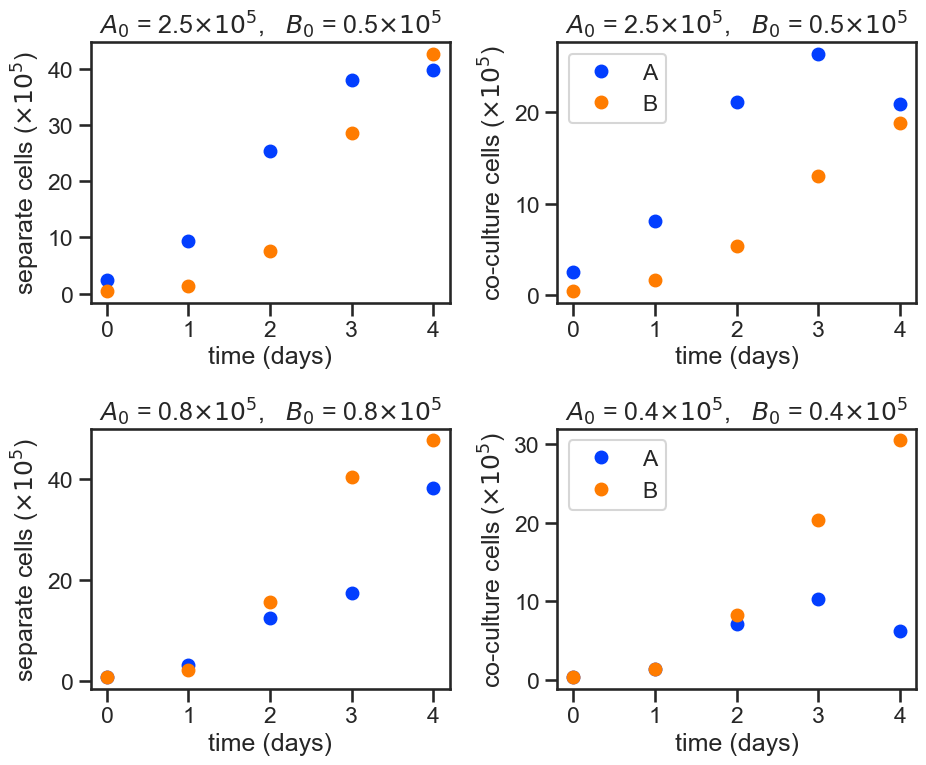

In [2]:
#### You can use the following libraries for your answers
import plot_functions as pf
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
pf.plot_experimental_trajectories()
plt.show()

## ODE model

We can get mechanistic understanding of this competition by using a set of ODEs including the net intrinsic growth of each species $\rho_A$, $\rho_B$; and the competition strengths $K_{N,N},K_{P,P},K_{N,P},K_{P,N}$

$$\begin{array}{rcl}
\dot A &=& \rho_A A - K_{A,A}A^2 - K_{A,B}AB  \\
\dot B &=& \rho_B B - K_{B,B}B^2- K_{B,A}AB  \\
\end{array} \hspace{2cm} (1)
$$

Different combinations of parameters encode different competition strategies with different temporal dynamics.

**Q1: What is the biological meaning of $K_{A,A}>K_{B,B}$? And $K_{A,B}>K_{A,A}$?**

<span style='color:Blue'> Answer  </span>

(Write your answer here)

## Competition trajectories

For each set of parameters $\theta = (\rho_A,\rho_B,K_{A,A},K_{B,B},K_{A,B},K_{B,A})$ and a given initial condition, the equations (1) can be solved numerically. The following code does so using the Scipy ODE solver [solver_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp).

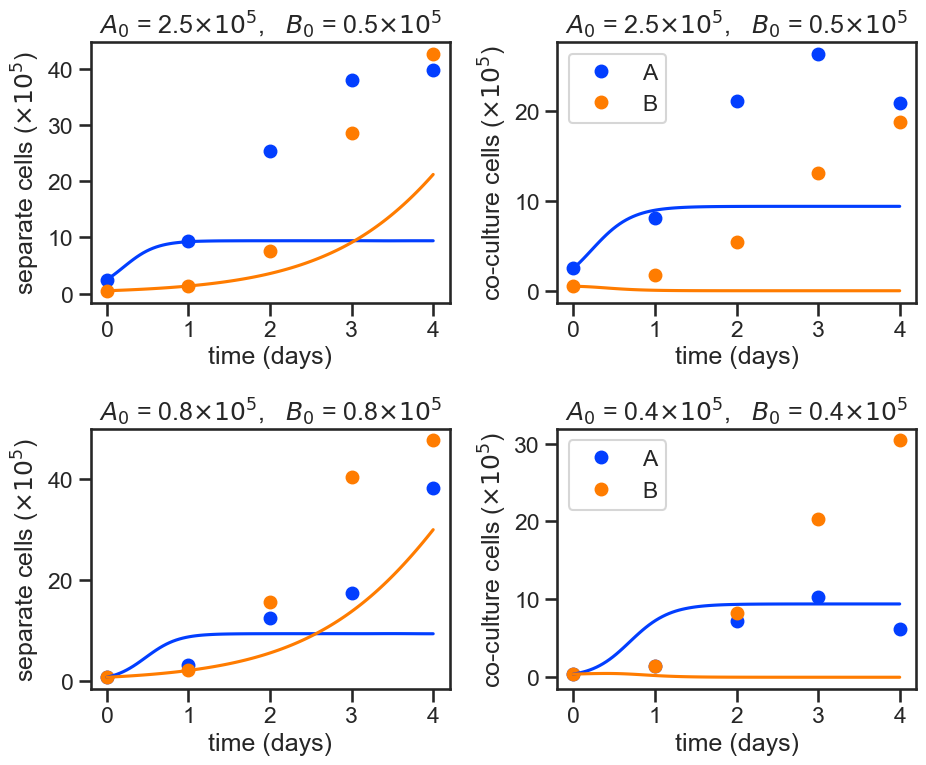

In [3]:
import plot_functions as pf
#### You should modifiy the two following lines
rhoA, rhoB = 5.0 , 1.0
KAA, KBB, KAB, KBA = 0.5313 , 0.0107, 1.0, 0.5
############################################

def rhs_ODEs(t,c,rhoA, rhoB, KAA, KBB, KAB, KBA):
    return [c[0]*(rhoA-KAA*c[0]-KAB*c[1]),c[1]*(rhoB-KBB*c[1]-KBA*c[0])] ## ODEs definition

experimental_plot = pf.plot_experimental_trajectories() # plot experimental data
pf.plot_ODEs(experimental_plot, rhs_ODEs,rhoA, rhoB,KAA, KBB, KAB, KBA) # plot model prediction


**Q2: Try manually different parameter set values and find a parameter set that is able to fit the data**

<span style='color:Blue'> Answer  </span>

(Write your answer here)

## Marginal posterior distribution sampling

ABC-SMC was employed in order to obtain a distribution of parameters compatible with the data. This inferece was done on an extended input dataset using a distance function defined as the sum of least square Euclidean distances between each datapoint and the model prediction. In the absence of prior information of the system, flat prior distributions were used. The result of the ABC is a list of parameter sets $\theta$ sampling the posterior distribution stored in the file `ABC_output.npy`. The histogram of each individual parameter returns an approximation of the marginal posterior distribution:


min:0.6158939072625544,  max:1.6720778604271602,  median:1.4226405419960637


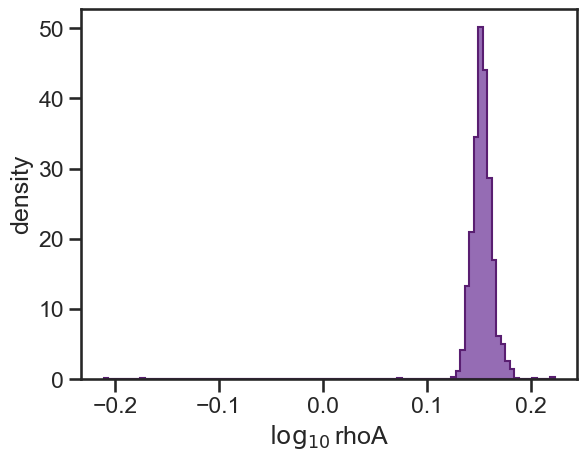

In [31]:
posterior = np.load('data/ABC_output.npy') # loading ABC-SMC results each column is a parameter, each row is a posterior point in parameter space
likelihoods = np.load('data/Likelihoods.npy').flatten()

sorted_idxs = likelihoods.argsort() # Sorting datapoint by order of likelihood
posterior = posterior[sorted_idxs] 
likelihoods = likelihoods[sorted_idxs]

def plot_marginal(par_name):

    pardict = {'rhoA':0, 'rhoB':1,'KAA':2, 'KBB':3, 'KAB':4, 'KBA':5} # Order of parameters in the file
    marginal_sample = posterior[:,pardict[par_name]]
    plt.hist(marginal_sample,histtype = 'stepfilled',
        color = sbcolorcyclemuted[4], edgecolor = sbcolorcycledark[4],
        density = True, bins = 100)
    plt.xlabel('$\\log_{10}$'+par_name)
    plt.ylabel('density')
    print('min:{},  max:{},  median:{}'.format(10**min(marginal_sample),10**max(marginal_sample),10**np.median(marginal_sample)))

#### Change the parameter in this line to plot different marginals
pf.plot_marginal('rhoA')
####


**Q3: Given an array of points of one of the marginal distributions (`marginal_sample` in the code above), one can attempt to use the function `scipy.stats.mode()` to find the maximum of the distribution (the maximum a posteriori). Why is this a bad idea?** 

<span style='color:Blue'> Answer  </span>

(Write your answer)

**Q4: Write a code that finds the Maximum a Posteriori (MAP) of each marginal distribution. You can use chatGPT to help you write the code, just make sure that you understand the output. Double check that the results are consistent by plotting together some marginal distributions and the corresponding MAPs.**

MAP at 0.15168764939585788
min:0.6158939072625544,  max:1.6720778604271602,  median:1.4226405419960637


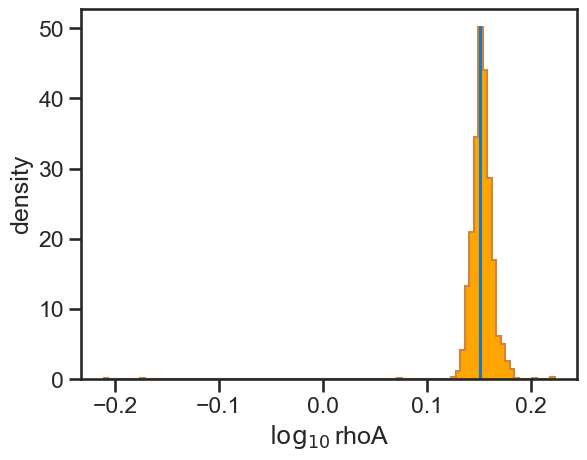

MAP at 0.1530834827723458
min:0.6158939072625544,  max:1.6720778604271602,  median:1.4226405419960637


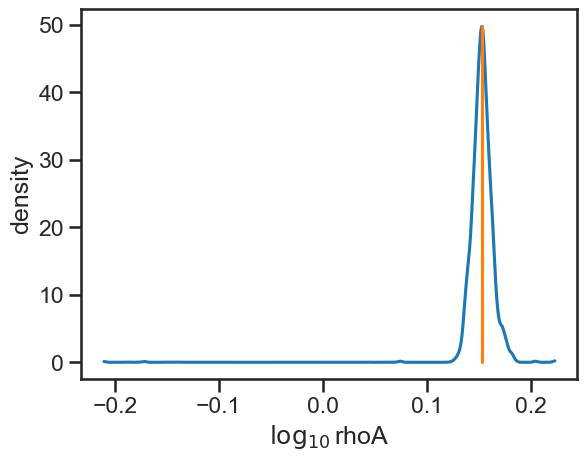

In [52]:
### Simplest way of doing this is finding the bin with max counts. We can modify our plot_marginal function to do this

def plot_marginal_MAP(par_name):

    pardict = {'rhoA':0, 'rhoB':1,'KAA':2, 'KBB':3, 'KAB':4, 'KBA':5} # Order of parameters in the file
    marginal_sample = posterior[:,pardict[par_name]]
    
    counts,bin_edges,p = plt.hist(marginal_sample,histtype = 'stepfilled',
        color = 'orange', edgecolor = 'peru',
        density = True, bins = 100)
    
    max_bin_index = np.argmax(counts)
    max_par = (bin_edges[max_bin_index + 1] + bin_edges[max_bin_index])/2
    print('MAP at {}'.format(max_par))
    plt.plot([max_par,max_par],[0,counts[max_bin_index]])
    
    plt.xlabel('$\\log_{10}$'+par_name)
    plt.ylabel('density')
    print('min:{},  max:{},  median:{}'.format(10**min(marginal_sample),10**max(marginal_sample),10**np.median(marginal_sample)))

#### Change the parameter in this line to plot different marginals
plot_marginal_MAP('rhoA')
####


#### An alternative way of doing this is generating a distribution using a KDE (Kernel Density Estimation)
from scipy.stats import gaussian_kde
from scipy import optimize
def plot_marginal(par_name):

    pardict = {'rhoA':0, 'rhoB':1,'KAA':2, 'KBB':3, 'KAB':4, 'KBA':5} # Order of parameters in the file
    marginal_sample = posterior[:,pardict[par_name]]
    
    kde = gaussian_kde(marginal_sample)
    xarray = np.linspace(np.min(marginal_sample), np.max(marginal_sample),1000)
    MAP_optimization = optimize.minimize_scalar(lambda x: -kde(x), bounds=(np.min(marginal_sample), np.max(marginal_sample)), method='bounded')
    MAP = (MAP_optimization.x)[0]
    
    plt.plot(xarray,kde(xarray))
    
    print('MAP at {}'.format(MAP))
    plt.plot([MAP,MAP],[0,kde(MAP)[0]])
    
    plt.xlabel('$\\log_{10}$'+par_name)
    plt.ylabel('density')
    print('min:{},  max:{},  median:{}'.format(10**min(marginal_sample),10**max(marginal_sample),10**np.median(marginal_sample)))

#### Change the parameter in this line to plot different marginals
plt.show()
plot_marginal('rhoA')



(Write your answer here)

**Q5: Explore the marginal distributions obtained for each parameter. Discuss if the parameters you found manually are similar to the Maximum a Posteriori and if they fall inside the HDR of the inference**

<span style='color:Blue'> Answer  </span>

(Write your answer here)

## Pairwise Joint distributions

In addition to the marginal distributions, pairwise joint distributions can also provide inferred information about the relationship between parameters. Pairwise Joint distribution can be visualized as scatterplot of the sampled parameters for each pair of parameters:

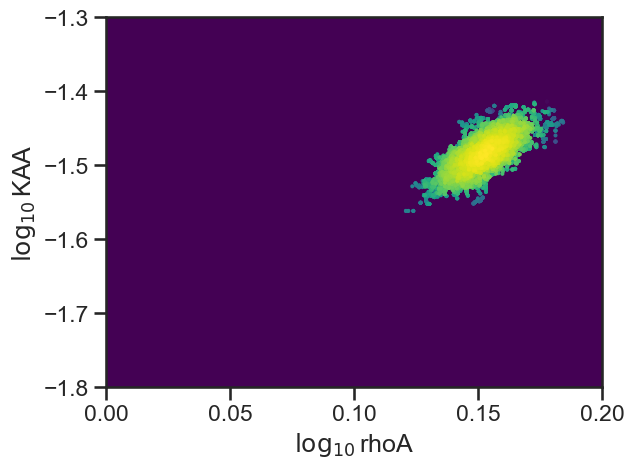

In [55]:
def plot_joint(par_name1,par_name2):

    pardict = {'rhoA':0, 'rhoB':1,'KAA':2, 'KBB':3, 'KAB':4, 'KBA':5} # Order of parameters in the file
    plt.scatter(posterior[:,pardict[par_name1]], posterior[:,pardict[par_name2]], c = likelihoods,
              s = 2, cmap = 'viridis', vmin = likelihoods[1000], vmax = likelihoods[-1])
    cmap =mpl.colormaps['viridis']
    plt.gca().set_facecolor(cmap(0))
    plt.xlabel('$\\log_{10}$'+par_name1)
    plt.ylabel('$\\log_{10}$'+par_name2)
    plt.xlim([0,0.2]) ## Uncomment these lines and change the values to customize the plotting range
    plt.ylim([-1.8,-1.3])

## Change the parameters in the following line to explore different parameter pairs
plot_joint('rhoA','KAA')

**Q6: Using the code above, explore the different pairwise joint distributions. Identify any parameter pair that exhibits a high correlation and discuss its biological meaning**

<span style='color:Blue'> Answer  </span>

(Write your answer)

**Q7: Discuss if the following statements are true and their biological implication (you may change the range of the plots, and plot additional lines on the plot to support your answer):**

**a) $\rho_A=\rho_B$**

**b) $K_{AA}>K_{BB}$**

**b) $K_{AB}\neq K_{AA}$**


<span style='color:Blue'> Answer  </span>

(Write your answer)

## References

[1] Hibbing, M., Fuqua, C., Parsek, M. et al. Bacterial competition: surviving and thriving in the microbial jungle. Nat Rev Microbiol 8, 15–25 (2010). https://doi.org/10.1038/nrmicro2259

[2] Zheng, C., Hu, Y., Sakurai, M. et al. Cell competition constitutes a barrier for interspecies chimerism. Nature 592, 272–276 (2021). https://doi.org/10.1038/s41586-021-03273-0

[3] Perez Montero, S., P.K. Paul, et al. Mutation of p53 increases the competitive ability of pluripotent stem cells. Development https://doi.org/10.1242/dev.202503

In [46]:
MAP

NameError: name 'MAP' is not defined